In [55]:
import pandas as pd
import numpy as np
from src.one_hot_encoding import encode_categorical_variable, join_to_df
from src.classification_class import CustomClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import train_test_split
from src.classification_class import CustomClassifier
import math
import scipy.stats as st
import numpy as np

In [2]:
import shap

/Users/kleomeniskogias/opt/anaconda3/envs/outra_kernel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [3]:
def string_to_list(input_string):
    output_list = input_string.split(",")
    output_list = [elem.strip() for elem in output_list]
    return output_list

def list_to_string(input_list):
    output_string = ', '.join(input_list)
    return output_string


def remove_consecutive_same_string(input_list):
    list_length = len(input_list)
    clean_list = []
    clean_list.append(input_list[0])
    for i in range(1, list_length):
        # print(i, clean_list, input_list[i])
        if (input_list[i] != input_list[i - 1]):
            clean_list.append(input_list[i])
    return clean_list

# Datasets

In [4]:
property_events = pd.read_csv("data/prop_events_for_test.csv")
print(property_events.shape)
properties = pd.read_csv("data/property_for_test.csv")
print(properties.shape)

(18922, 3)
(15101, 35)


In [5]:
# Check the ids
if properties['prop_id'].value_counts().max() > 1:
    print("There are duplicates in the propery id")
print(f"There are {properties['prop_id'].shape[0]} unique properties")
# Check the properties that we have historical data
properties_with_historical_data = properties.merge(property_events.drop_duplicates(subset = ['prop_id']), on = 'prop_id')['prop_id']
print(f"There are {properties_with_historical_data.shape[0]} properties with historical data")

There are 15101 unique properties
There are 6514 properties with historical data


# Rules Assignment

If the most recent event of a property is 'sale' or 'l_sold' label the Inhabitant status as 'Homeowner'. <br>
If the most recent event of a property is 'l_rented'  label the Inhabitant status as 'Rented'.

In [15]:
decisive_events = ['sale', 'l_rented', 'l_sold']

# latest_event 
latest_event = property_events.groupby(['prop_id'])['day'].max().reset_index()
latest_event = latest_event.merge(property_events, on = ['prop_id', 'day'])[['prop_id', 'day', 'type']]
labeled_data = latest_event[latest_event['type'].isin(decisive_events)]
labeled_data['Label'] = labeled_data['type'].apply(lambda x : 'Homeowner' if x in ['sale', 'l_sold'] else 'Renters')
labeled_data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,prop_id,day,type,Label
0,129114,2016-02-16,sale,Homeowner
2,129451,2018-05-10,l_rented,Renters
9,129853,2014-10-22,l_rented,Renters
12,129937,2018-04-20,l_sold,Homeowner
17,130114,2018-03-08,l_rented,Renters
...,...,...,...,...
6507,456054,2017-05-24,sale,Homeowner
6508,456386,2016-03-11,sale,Homeowner
6509,456969,2017-01-06,sale,Homeowner
6510,457708,2017-07-13,sale,Homeowner


## Property events

1995-01-06 2018-07-07


<AxesSubplot: title={'center': 'Historic data points per property'}, xlabel='frequency'>

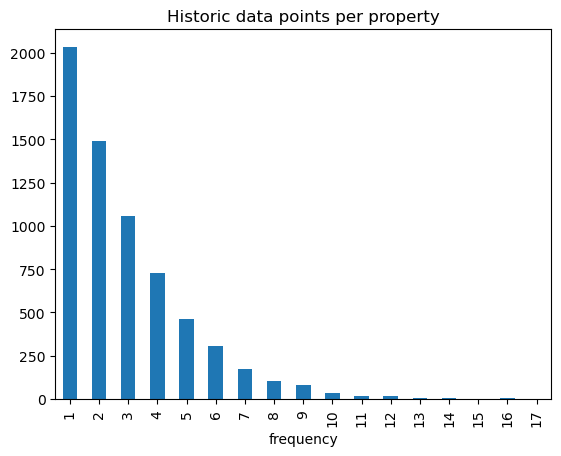

In [6]:
# Understand the historical data
property_events['day'] = property_events['date'].apply(lambda x : x [0:10])
print(property_events['day'].min(), property_events['day'].max())
# Property events frequency
property_events_freq = property_events['prop_id'].value_counts().reset_index().rename(columns = {'index': 'prop_id', 'prop_id' : 'frequency'})
property_events_freq.groupby(['frequency'])['prop_id'].count().plot.bar(title= "Historic data points per property")

In [8]:
property_events_freq['frequency'].mean()

2.9048203868590727

In [9]:
# Histogram of type of events
property_events['type'].value_counts()#.plot.bar()

survey                13063
sale                   1641
l_rent                 1408
l_rented                968
l_for_sale              885
l_sold                  767
l_sale_under_offer      115
l_rent_under_offer       75
Name: type, dtype: int64

In [10]:
series_of_actions = property_events.sort_values('date').groupby(['prop_id']).agg({'type': ', '.join}).reset_index().rename(columns = {'type' : 'series_of_actions'})
series_of_actions['series_of_actions'].value_counts().to_frame()
series_of_actions["non_consequtive"] = series_of_actions['series_of_actions'].apply(lambda x : list_to_string(remove_consecutive_same_string(string_to_list(x))) )
series_of_actions["non_consequtive"] .value_counts().head(20)

survey                                        3857
survey, sale                                   562
sale                                           178
survey, l_rent, l_rented                       152
survey, l_rent                                 148
l_rent                                         147
survey, l_for_sale, l_sold, sale               109
l_rent, l_rented                               102
survey, l_for_sale, l_sold, survey, sale        60
l_for_sale, l_sold, sale                        48
survey, l_rented                                45
survey, sale, survey                            45
survey, l_for_sale, l_sold                      44
l_rented                                        37
l_for_sale, l_sold                              36
survey, l_for_sale                              36
survey, l_for_sale, sale                        32
survey, l_rent, l_rented, l_rent, l_rented      31
l_for_sale                                      30
survey, l_sold, sale           

In [16]:
# Subsets
# Data for which we have historical events
properties_with_historical_data_df = properties_with_historical_data.to_frame().merge(properties, on= 'prop_id')
print(properties_with_historical_data_df.shape)
# Labeled data - data that we can label them by using the rules above
labeled_data_all_columns = labeled_data.merge(properties, on = 'prop_id')
print(labeled_data_all_columns.shape)


(6514, 35)
(1965, 38)


## Properties

In [17]:
properties.groupby(['post_town', 'postcode_sector'])['prop_id'].count()

post_town  postcode_sector
BRISTOL    BS6 5              5404
           BS6 6              5717
           BS6 7              3980
Name: prop_id, dtype: int64

<AxesSubplot: title={'center': 'Floor area'}, ylabel='Frequency'>

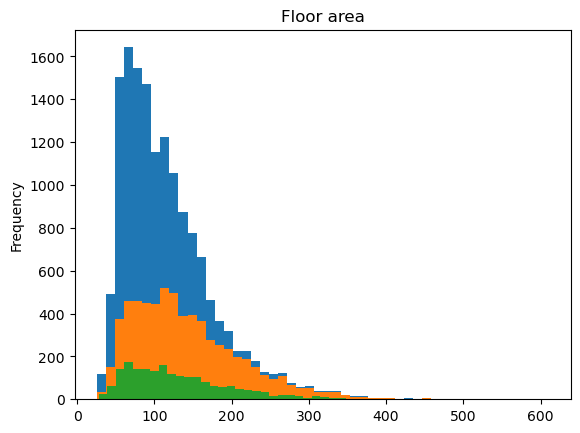

In [18]:
# Floor area
properties['floor_area'].plot.hist(bins=50, title = "Floor area")
properties_with_historical_data_df['floor_area'].plot.hist(bins=50, title = "Floor area")
labeled_data_all_columns['floor_area'].plot.hist(bins=50, title = "Floor area")

<AxesSubplot: title={'center': 'Year Built'}, ylabel='Frequency'>

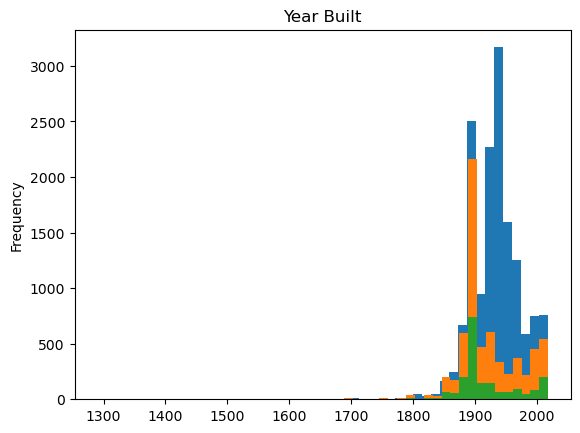

In [19]:
# Year built
properties['year_built'].plot.hist(bins=50, title = "Year Built")
properties_with_historical_data_df['year_built'].plot.hist(bins=50, title = "Year Built")
labeled_data_all_columns['year_built'].plot.hist(bins=50, title = "Year Built")

<AxesSubplot: ylabel='Frequency'>

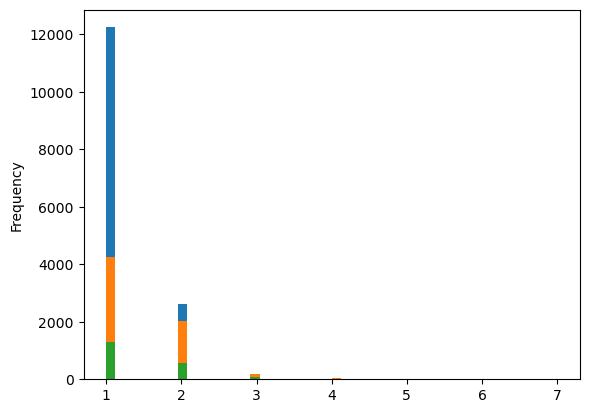

In [20]:
# Number of bathrooms
properties['bathrooms'].plot.hist(bins=50)
properties_with_historical_data_df['bathrooms'].plot.hist(bins=50)
labeled_data_all_columns['bathrooms'].plot.hist(bins=50)

<AxesSubplot: title={'center': 'Bedrooms'}, ylabel='Frequency'>

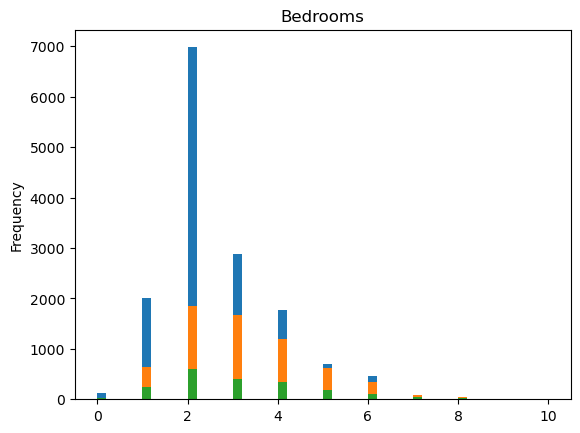

In [21]:
# Number of bedrooms
properties['bedrooms'].plot.hist(bins=50, title = "Bedrooms")
properties_with_historical_data_df['bedrooms'].plot.hist(bins=50, title = "Bedrooms")
labeled_data_all_columns['bedrooms'].plot.hist(bins=50, title = "Bedrooms")

<AxesSubplot: title={'center': 'property_rental_value'}, ylabel='Frequency'>

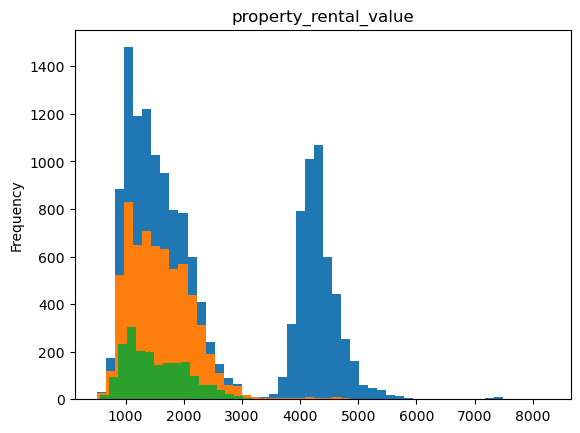

In [22]:
# Property rental value distribution
properties['property_rental_value'].plot.hist(bins=50, title = "property_rental_value")
properties_with_historical_data_df['property_rental_value'].plot.hist(bins=50, title = "property_rental_value")
labeled_data_all_columns['property_rental_value'].plot.hist(bins=50, title = "property_rental_value")

It seems that we do not get data from agencies that rent extremely expensive properties

array([<AxesSubplot: title={'center': 'Homeowner'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': 'Renters'}, ylabel='Frequency'>],
      dtype=object)

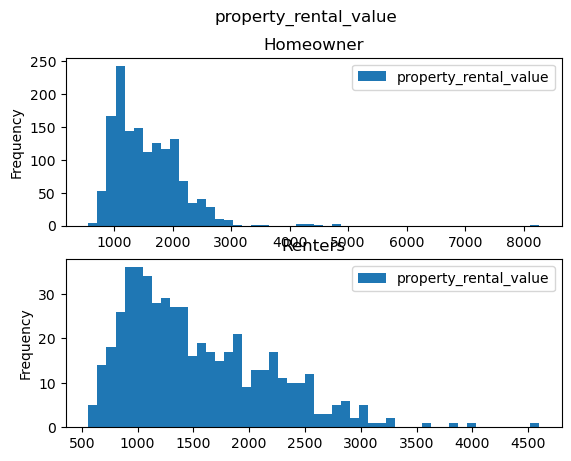

In [23]:
# Rental value distribution per Label
labeled_data_all_columns[['property_rental_value', 'Label']].plot.hist(bins=50, title = "property_rental_value", by = 'Label')

<AxesSubplot: title={'center': 'property_rental_value'}, ylabel='Frequency'>

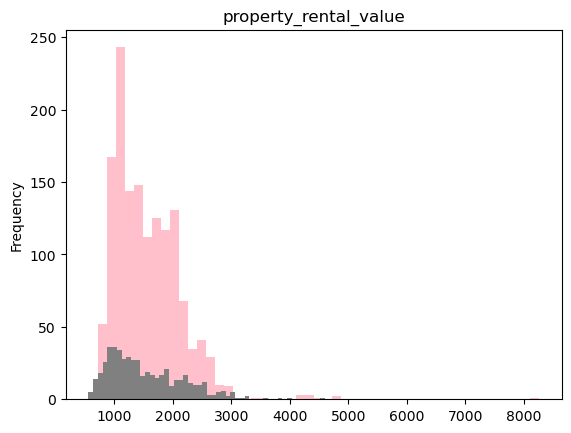

In [24]:
# Property rental value inn the same chart
labeled_data_all_columns[labeled_data_all_columns['Label'] == 'Homeowner']['property_rental_value'].plot.hist(bins=50, title = "property_rental_value", color='Pink')
labeled_data_all_columns[labeled_data_all_columns['Label'] == 'Renters']['property_rental_value'].plot.hist(bins=50, title = "property_rental_value", color='Grey')


<AxesSubplot: title={'center': 'property_value'}, ylabel='Frequency'>

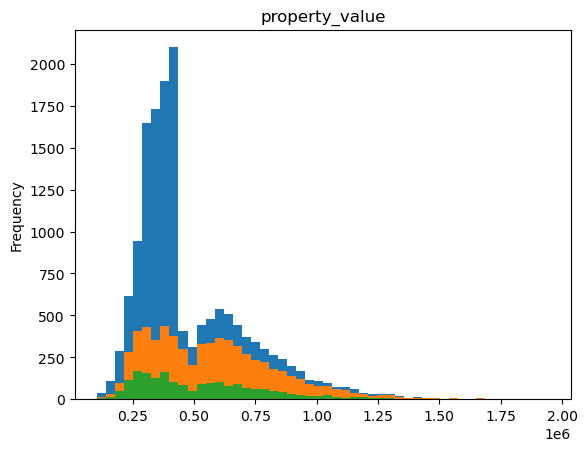

In [25]:
# Property value
properties['property_value'].plot.hist(bins=50, title = "property_value")
properties_with_historical_data_df['property_value'].plot.hist(bins=50, title = "property_value")
labeled_data_all_columns['property_value'].plot.hist(bins=50, title = "property_value")

array([<AxesSubplot: title={'center': 'Homeowner'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': 'Renters'}, ylabel='Frequency'>],
      dtype=object)

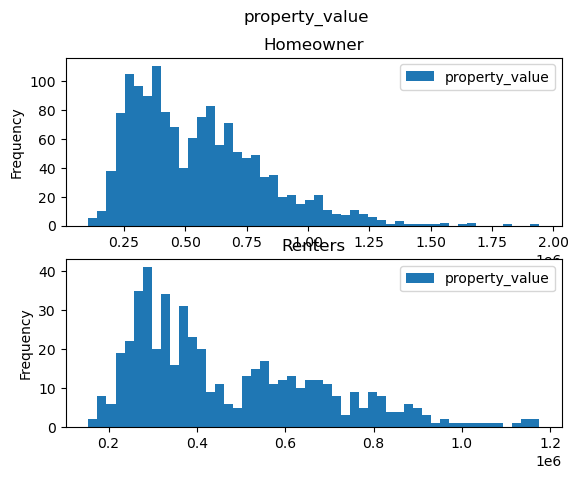

In [26]:
# Property value per label
labeled_data_all_columns[['property_value', 'Label']].plot.hist(bins=50, title = "property_value", by = 'Label')

<AxesSubplot: title={'center': 'ht_property_type'}, xlabel='ht_property_type'>

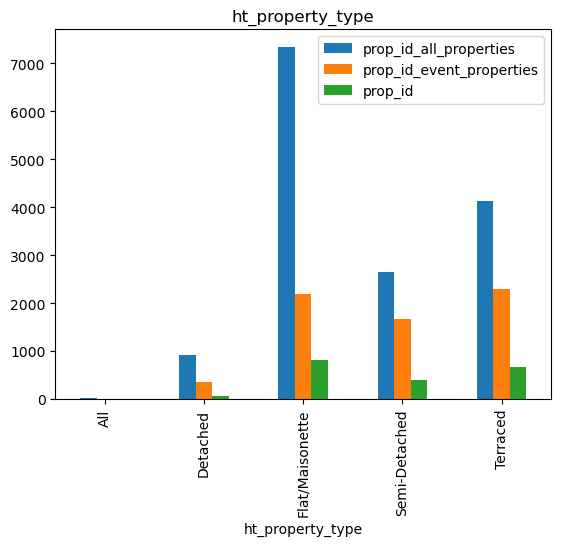

In [27]:
# Property type bar plot
groupby1 = properties.groupby('ht_property_type')[['prop_id']].count()
groupby2 = properties_with_historical_data_df.groupby('ht_property_type')[['prop_id']].count()
groupby3 = labeled_data_all_columns.groupby('ht_property_type')[['prop_id']].count()
merged_groupbys = groupby1.join(groupby2, lsuffix = '_all_properties', rsuffix='_event_properties').join(groupby3, rsuffix='labeled')
merged_groupbys.plot.bar(title = 'ht_property_type')

In [28]:
# Property type istribution per label
property_type_pivot_table = pd.pivot_table(data = labeled_data_all_columns, columns= 'Label', index = 'ht_property_type', values = 'prop_id', aggfunc='count')
property_type_pivot_table = property_type_pivot_table.div(property_type_pivot_table.sum(), axis =1) * 100
property_type_pivot_table

Label,Homeowner,Renters
ht_property_type,,
All,0.206469,0.390625
Detached,3.647626,3.125000
Flat/Maisonette,37.646249,53.906250
Semi-Detached,22.642808,12.500000
Terraced,35.856848,30.078125


<AxesSubplot: title={'center': 'Postcodes'}, xlabel='postcode_sector'>

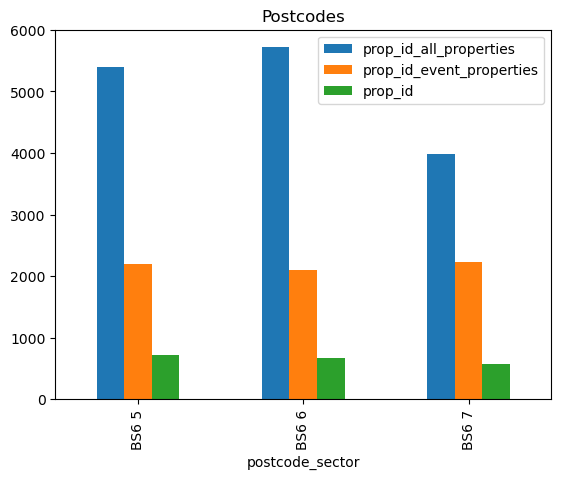

In [29]:
# Postcodes bar chart
groupby1 = properties.groupby('postcode_sector')[['prop_id']].count()
groupby2 = properties_with_historical_data_df.groupby('postcode_sector')[['prop_id']].count()
groupby3 = labeled_data_all_columns.groupby('postcode_sector')[['prop_id']].count()
merged_groupbys = groupby1.join(groupby2, lsuffix = '_all_properties', rsuffix='_event_properties').join(groupby3, rsuffix='labeled')
merged_groupbys.plot.bar(title = 'Postcodes')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


<AxesSubplot: xlabel='x_coordinate', ylabel='y_coordinate'>

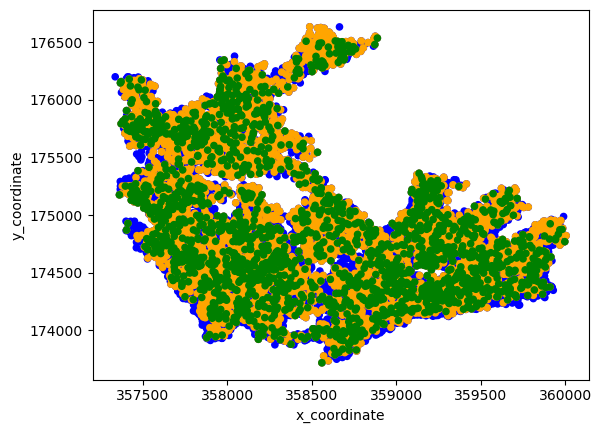

In [30]:
# X-coordinate, Y-coordinate scatter plot
properties_scatter = properties[['prop_id', 'x_coordinate', 'y_coordinate']]
properties_scatter['source'] = 'Blue'
properties_events_scatter = properties_with_historical_data_df[['prop_id', 'x_coordinate', 'y_coordinate']]
properties_events_scatter['source'] = 'Orange'
labeled_events_scatter = labeled_data_all_columns[['prop_id', 'x_coordinate', 'y_coordinate']]
labeled_events_scatter['source'] = 'Green'
scattered_all = properties_scatter.append([properties_events_scatter, labeled_events_scatter])
scattered_all.plot.scatter(x = 'x_coordinate', y = 'y_coordinate', c='source')


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


<AxesSubplot: title={'center': 'Homeowner/Renters geolocation'}, xlabel='x_coordinate', ylabel='y_coordinate'>

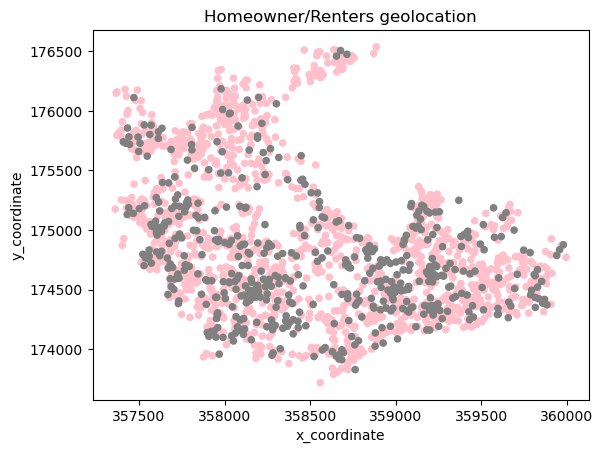

In [31]:
# X-coordinate, Y-coordinate scatter plot per label
Homeowner_scatter = labeled_data_all_columns[labeled_data_all_columns['Label'] == 'Homeowner'][['prop_id', 'x_coordinate', 'y_coordinate']]
Homeowner_scatter['source'] = 'Pink'
Renters_scatter = labeled_data_all_columns[labeled_data_all_columns['Label'] == 'Renters'][['prop_id', 'x_coordinate', 'y_coordinate']]
Renters_scatter['source'] = 'Grey'
scattered_all = Homeowner_scatter.append([Renters_scatter])
scattered_all.plot.scatter(x = 'x_coordinate', y = 'y_coordinate', c='source', title = "Homeowner/Renters geolocation")

# Classification

In [33]:
training_features = ['x_coordinate', 'y_coordinate', 'bathrooms','bedrooms',
 'floor_area', 'year_built', 'property_value', 'property_rental_value']
to_encode = ['postcode_sector', 'property_type', 'ht_property_type', 'tenure'] #'property_style'


In [34]:
# Properties info in order to understand where does the missing values are coming from
properties[training_features + to_encode].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15101 entries, 0 to 15100
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   x_coordinate           15101 non-null  float64
 1   y_coordinate           15101 non-null  float64
 2   bathrooms              15072 non-null  float64
 3   bedrooms               15065 non-null  float64
 4   floor_area             15071 non-null  float64
 5   year_built             15061 non-null  float64
 6   property_value         15090 non-null  float64
 7   property_rental_value  15090 non-null  float64
 8   postcode_sector        15101 non-null  object 
 9   property_type          15081 non-null  object 
 10  ht_property_type       15086 non-null  object 
 11  tenure                 15083 non-null  object 
dtypes: float64(8), object(4)
memory usage: 1.4+ MB


In [36]:
# One-Hot-Encode categorical variables
all_encoded_data = pd.DataFrame()
for col in to_encode:
    encoded_data = encode_categorical_variable(input_df=properties, col_name = col, id_col = 'prop_id')
    all_encoded_data = join_to_df(encoded_data, all_encoded_data)

all_encoded_data    

,postcode_sector_BS6 5,postcode_sector_BS6 6,postcode_sector_BS6 7,property_type_Bungalow/Chalet,property_type_Flat/Maisonette,property_type_House,ht_property_type_All,ht_property_type_Detached,ht_property_type_Flat/Maisonette,ht_property_type_Semi-Detached,ht_property_type_Terraced,tenure_Feudal,tenure_Freehold,tenure_Leasehold,tenure_Shared
prop_id,,,,,,,,,,,,,,,
147676,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
152958,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
154711,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
155062,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
158773,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163710,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0
143377,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0
388773,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0


In [37]:
# Build the dataset that is going to be used for the classification purpose
classification_data = (properties[['prop_id'] + training_features].set_index('prop_id').join(all_encoded_data).reset_index())
classification_data = classification_data.merge(labeled_data[['prop_id', 'Label']], on = 'prop_id')
print(classification_data.shape)
classification_data = classification_data.dropna()
print(classification_data.shape)

(1965, 25)
(1952, 25)


In [38]:
# Train, validation and test set
label = ['Label']
training_columns = [col for col in classification_data.columns if col not in ['prop_id', 'Label']]
X = classification_data[training_columns + ['prop_id']].set_index('prop_id')
y = classification_data[label + ['prop_id']].set_index('prop_id')
from sklearn.model_selection import train_test_split
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


(1171, 23) (1171, 1) (390, 23) (390, 1) (391, 23) (391, 1)


In [39]:
# Unbalanced dataset
y.value_counts()['Homeowner']/y.shape[0]

0.7387295081967213

In [40]:
# import src.classification_class
# import importlib
# importlib.reload(src.classification_class)

In [41]:

# Random Forest
print(" --------------------- RF --------------------")
classifiers_outputs = {}
rf = CustomClassifier("RF")
rf.set_train_and_test_data(X_train, X_val, y_train, y_val)
rf.fit_model()
rf.estimate_accuracy()
rf.estimate_precision()
rf.estimate_f1_score()
rf.estimate_training_accuracy()

# Logistic Regression
print(" --------------------- LR --------------------")
lr = CustomClassifier("LR")
lr.set_train_and_test_data(X_train, X_val, y_train, y_val)
lr.fit_model()

lr.estimate_accuracy()
lr.estimate_precision()
lr.estimate_f1_score()
lr.estimate_training_accuracy()

# XGBoost
print(" --------------------- XGB --------------------")
xgb = CustomClassifier("XGBoost")
xgb.set_train_and_test_data(X_train, X_val, y_train, y_val)
xgb.fit_model()
xgb.estimate_accuracy()
xgb.estimate_precision()
xgb.estimate_f1_score()
xgb.estimate_training_accuracy()

 --------------------- RF --------------------
RF
Accuracy of RF classifier on test set: 0.7846
Precision of RF classifier on test set: 0.7691
F1-score (unweighted) of RF classifier on test set: 0.6728
F1-score (weigthed) of RF classifier on test set: 0.7621


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy of RF classifier on training set: 0.9991
 --------------------- LR --------------------
LR
Accuracy of LR classifier on test set: 0.7256
Precision of LR classifier on test set: 0.6142
F1-score (unweighted) of LR classifier on test set: 0.4380
F1-score (weigthed) of LR classifier on test set: 0.6257
Accuracy of LR classifier on training set: 0.7387
 --------------------- XGB --------------------
XGBoost
[11:41:39] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Accuracy of XGBoost classifier on test set: 0.7513
Precision of XGBoost classifier on test set: 0.7276
F1-score (unweighted) of XGBoost classifier on test set: 0.6336
F1-score (weigthed) of XGBoost classifier on test set: 0.7305
Accuracy of XGBoost classifier on training set: 1.0000


1.0

In [42]:
# Results formatted
classifiers_list = [rf, lr, xgb]
classifiers_outputs = pd.DataFrame(columns = ["RF", "LR", "XGBoost"], index = ["Accuracy" , "Precision", "F1_score unweighted", "F1_score weighted"])
for classifier in classifiers_list:
    classifiers_outputs.loc['Training Accuracy', classifier.model] = round(classifier.training_accuracy, 3)
    classifiers_outputs.loc['Accuracy', classifier.model] = round(classifier.accuracy, 3)
    classifiers_outputs.loc['Precision', classifier.model] = round(classifier.precision, 3)
    classifiers_outputs.loc['F1_score unweighted', classifier.model] = round(classifier.f1_score_macro, 3)
    classifiers_outputs.loc['F1_score weighted', classifier.model] = round(classifier.f1_score_weighted, 3)

classifiers_outputs.T#.to_clipboard()

,Accuracy,Precision,F1_score unweighted,F1_score weighted,Training Accuracy
RF,0.785,0.769,0.673,0.762,0.999
LR,0.726,0.614,0.438,0.626,0.739
XGBoost,0.751,0.728,0.634,0.731,1.0


In [43]:
classifiers_outputs.T.to_clipboard()

# Check for statistical significance

Run test-statistic to check the confidence of the fact that the Random Forest classifier is performing better than the XGBoost: <br>
<br>
H0: Random Forest and XGBoost have the same accuracy performance <br>
H1: Random Forest performs better than XGBoost

In [51]:
# Two proportion z-test
p1  = rf.accuracy
p2 = xgb.accuracy
n = X_val.shape[0]
x1 = round(p1 * n)
x2 = round(p2 * n)
p = (x1+x2)/(2*n)
# print(p1, p2, n, x1, x2, p)
Z = (p1 - p2)/(math.sqrt((2*p*(1-p)/n)))
print(f"Z = {round(Z, 4)}")

print(f"With confidence of {round(st.norm.cdf(Z)*100, 1)} % Random Forest performs better than XGBoost")

Z = 1.1015
With confidence of 86.5 % Random Forest performs better than XGBoost


# AI Explainability

## Feature Importance (defeault)

In [169]:
rf.estimate_feature_importance()

,Feature,Significance
7,property_rental_value,0.150716
6,property_value,0.130876
1,y_coordinate,0.122811
4,floor_area,0.118552
0,x_coordinate,0.117809
5,year_built,0.105412
3,bedrooms,0.100888
21,tenure_Leasehold,0.023565
2,bathrooms,0.019948
20,tenure_Freehold,0.018845


## Shapley Values

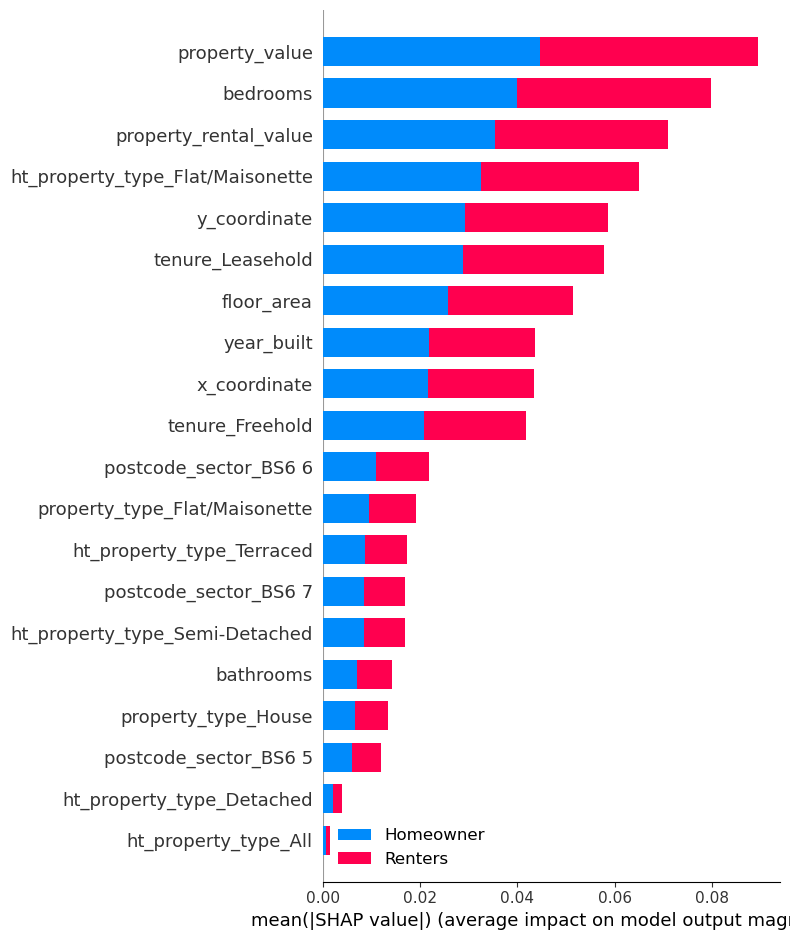

In [53]:
# Feature Importance
explainer = shap.TreeExplainer(rf.classifier)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= list(y['Label'].drop_duplicates()), feature_names = X.columns)

The feature importance derving from the Shapley values is slightly different compared to the one coming from the default module of Random Forest, as these two approaches are using a different underlying approach. In both cases, the property (rental) value, the y-coordinate and the bedrooms are 3 features with high importance.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


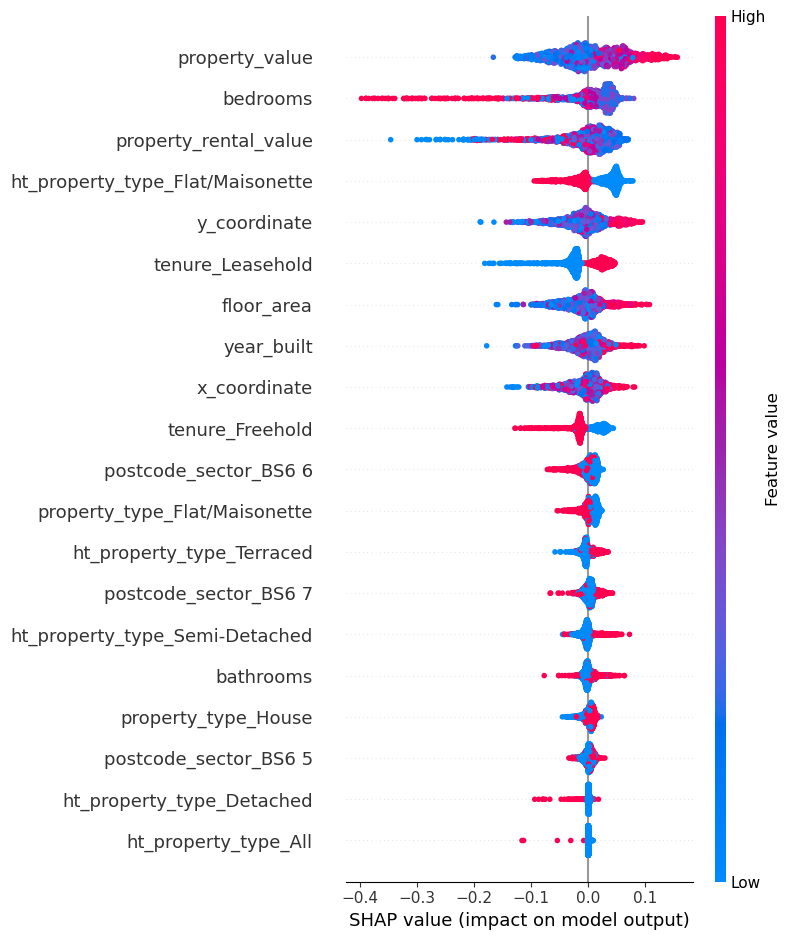

In [54]:
shap.summary_plot(shap_values[0], X.values, feature_names = X.columns)

# Model Optimisation

In [62]:
split_index = [-1 if x in rf.X_train.index else 0 for x in X_train.append(X_val).index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)
print(len(split_index))


parameters = {
    'max_depth': [5, 10, 50, 100],
    'n_estimators': [50, 100, 200, 500, 1000],
    'min_samples_leaf' : [3, 5, 10, 50],
    'max_features' : ['auto', 0.4 ]
}

random_search = RandomizedSearchCV(
    estimator=rf.classifier,
    param_distributions =parameters,
    n_iter= 50,
    scoring = 'accuracy',
    n_jobs = 1,
    cv = pds,
    verbose=10,
    random_state=7
)

1561


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [63]:
%%time
random_search.fit(X_train.append(X_val), y_train.append(y_val))

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fitting 1 folds for each of 50 candidates, totalling 50 fits
[CV 1/1; 1/50] START max_depth=50, max_features=0.4, min_samples_leaf=3, n_estimators=1000
[CV 1/1; 1/50] END max_depth=50, max_features=0.4, min_samples_leaf=3, n_estimators=1000;, score=0.785 total time=   2.2s
[CV 1/1; 2/50] START max_depth=50, max_features=auto, min_samples_leaf=5, n_estimators=500


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 2/50] END max_depth=50, max_features=auto, min_samples_leaf=5, n_estimators=500;, score=0.790 total time=   0.6s
[CV 1/1; 3/50] START max_depth=10, max_features=auto, min_samples_leaf=3, n_estimators=50
[CV 1/1; 3/50] END max_depth=10, max_features=auto, min_samples_leaf=3, n_estimators=50;, score=0.782 total time=   0.1s
[CV 1/1; 4/50] START max_depth=50, max_features=auto, min_samples_leaf=3, n_estimators=200


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 4/50] END max_depth=50, max_features=auto, min_samples_leaf=3, n_estimators=200;, score=0.790 total time=   0.3s
[CV 1/1; 5/50] START max_depth=50, max_features=auto, min_samples_leaf=50, n_estimators=1000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 5/50] END max_depth=50, max_features=auto, min_samples_leaf=50, n_estimators=1000;, score=0.733 total time=   1.0s
[CV 1/1; 6/50] START max_depth=10, max_features=0.4, min_samples_leaf=50, n_estimators=1000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 6/50] END max_depth=10, max_features=0.4, min_samples_leaf=50, n_estimators=1000;, score=0.733 total time=   1.3s
[CV 1/1; 7/50] START max_depth=10, max_features=0.4, min_samples_leaf=50, n_estimators=200


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 7/50] END max_depth=10, max_features=0.4, min_samples_leaf=50, n_estimators=200;, score=0.733 total time=   0.3s
[CV 1/1; 8/50] START max_depth=100, max_features=auto, min_samples_leaf=5, n_estimators=50
[CV 1/1; 8/50] END max_depth=100, max_features=auto, min_samples_leaf=5, n_estimators=50;, score=0.779 total time=   0.1s
[CV 1/1; 9/50] START max_depth=10, max_features=0.4, min_samples_leaf=5, n_estimators=100


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 9/50] END max_depth=10, max_features=0.4, min_samples_leaf=5, n_estimators=100;, score=0.797 total time=   0.2s
[CV 1/1; 10/50] START max_depth=50, max_features=0.4, min_samples_leaf=50, n_estimators=50
[CV 1/1; 10/50] END max_depth=50, max_features=0.4, min_samples_leaf=50, n_estimators=50;, score=0.733 total time=   0.1s
[CV 1/1; 11/50] START max_depth=5, max_features=0.4, min_samples_leaf=3, n_estimators=1000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 11/50] END max_depth=5, max_features=0.4, min_samples_leaf=3, n_estimators=1000;, score=0.754 total time=   1.5s
[CV 1/1; 12/50] START max_depth=100, max_features=0.4, min_samples_leaf=50, n_estimators=100
[CV 1/1; 12/50] END max_depth=100, max_features=0.4, min_samples_leaf=50, n_estimators=100;, score=0.733 total time=   0.1s
[CV 1/1; 13/50] START max_depth=5, max_features=auto, min_samples_leaf=10, n_estimators=500


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 13/50] END max_depth=5, max_features=auto, min_samples_leaf=10, n_estimators=500;, score=0.764 total time=   0.5s
[CV 1/1; 14/50] START max_depth=100, max_features=0.4, min_samples_leaf=5, n_estimators=500


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 14/50] END max_depth=100, max_features=0.4, min_samples_leaf=5, n_estimators=500;, score=0.795 total time=   1.0s
[CV 1/1; 15/50] START max_depth=100, max_features=auto, min_samples_leaf=5, n_estimators=500


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 15/50] END max_depth=100, max_features=auto, min_samples_leaf=5, n_estimators=500;, score=0.790 total time=   0.6s
[CV 1/1; 16/50] START max_depth=10, max_features=0.4, min_samples_leaf=50, n_estimators=500


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 16/50] END max_depth=10, max_features=0.4, min_samples_leaf=50, n_estimators=500;, score=0.733 total time=   0.7s
[CV 1/1; 17/50] START max_depth=10, max_features=auto, min_samples_leaf=5, n_estimators=50
[CV 1/1; 17/50] END max_depth=10, max_features=auto, min_samples_leaf=5, n_estimators=50;, score=0.787 total time=   0.1s
[CV 1/1; 18/50] START max_depth=5, max_features=auto, min_samples_leaf=10, n_estimators=100
[CV 1/1; 18/50] END max_depth=5, max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.769 total time=   0.1s
[CV 1/1; 19/50] START max_depth=100, max_features=0.4, min_samples_leaf=50, n_estimators=1000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 19/50] END max_depth=100, max_features=0.4, min_samples_leaf=50, n_estimators=1000;, score=0.733 total time=   1.3s
[CV 1/1; 20/50] START max_depth=5, max_features=0.4, min_samples_leaf=5, n_estimators=500


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 20/50] END max_depth=5, max_features=0.4, min_samples_leaf=5, n_estimators=500;, score=0.751 total time=   0.7s
[CV 1/1; 21/50] START max_depth=10, max_features=0.4, min_samples_leaf=10, n_estimators=50
[CV 1/1; 21/50] END max_depth=10, max_features=0.4, min_samples_leaf=10, n_estimators=50;, score=0.785 total time=   0.1s
[CV 1/1; 22/50] START max_depth=100, max_features=0.4, min_samples_leaf=10, n_estimators=1000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 22/50] END max_depth=100, max_features=0.4, min_samples_leaf=10, n_estimators=1000;, score=0.795 total time=   1.9s
[CV 1/1; 23/50] START max_depth=10, max_features=auto, min_samples_leaf=10, n_estimators=100
[CV 1/1; 23/50] END max_depth=10, max_features=auto, min_samples_leaf=10, n_estimators=100;, score=0.785 total time=   0.1s
[CV 1/1; 24/50] START max_depth=5, max_features=0.4, min_samples_leaf=10, n_estimators=200


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 24/50] END max_depth=5, max_features=0.4, min_samples_leaf=10, n_estimators=200;, score=0.762 total time=   0.3s
[CV 1/1; 25/50] START max_depth=50, max_features=0.4, min_samples_leaf=10, n_estimators=100
[CV 1/1; 25/50] END max_depth=50, max_features=0.4, min_samples_leaf=10, n_estimators=100;, score=0.797 total time=   0.2s
[CV 1/1; 26/50] START max_depth=100, max_features=auto, min_samples_leaf=10, n_estimators=50


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 26/50] END max_depth=100, max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.777 total time=   0.1s
[CV 1/1; 27/50] START max_depth=50, max_features=auto, min_samples_leaf=3, n_estimators=1000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 27/50] END max_depth=50, max_features=auto, min_samples_leaf=3, n_estimators=1000;, score=0.785 total time=   1.4s
[CV 1/1; 28/50] START max_depth=50, max_features=auto, min_samples_leaf=3, n_estimators=50
[CV 1/1; 28/50] END max_depth=50, max_features=auto, min_samples_leaf=3, n_estimators=50;, score=0.777 total time=   0.1s
[CV 1/1; 29/50] START max_depth=5, max_features=0.4, min_samples_leaf=50, n_estimators=200


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 29/50] END max_depth=5, max_features=0.4, min_samples_leaf=50, n_estimators=200;, score=0.733 total time=   0.3s
[CV 1/1; 30/50] START max_depth=10, max_features=0.4, min_samples_leaf=5, n_estimators=50
[CV 1/1; 30/50] END max_depth=10, max_features=0.4, min_samples_leaf=5, n_estimators=50;, score=0.790 total time=   0.1s
[CV 1/1; 31/50] START max_depth=50, max_features=auto, min_samples_leaf=50, n_estimators=500


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 31/50] END max_depth=50, max_features=auto, min_samples_leaf=50, n_estimators=500;, score=0.733 total time=   0.5s
[CV 1/1; 32/50] START max_depth=10, max_features=0.4, min_samples_leaf=3, n_estimators=50
[CV 1/1; 32/50] END max_depth=10, max_features=0.4, min_samples_leaf=3, n_estimators=50;, score=0.787 total time=   0.1s
[CV 1/1; 33/50] START max_depth=10, max_features=auto, min_samples_leaf=5, n_estimators=100


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 33/50] END max_depth=10, max_features=auto, min_samples_leaf=5, n_estimators=100;, score=0.787 total time=   0.1s
[CV 1/1; 34/50] START max_depth=10, max_features=auto, min_samples_leaf=5, n_estimators=1000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 34/50] END max_depth=10, max_features=auto, min_samples_leaf=5, n_estimators=1000;, score=0.785 total time=   1.3s
[CV 1/1; 35/50] START max_depth=100, max_features=auto, min_samples_leaf=3, n_estimators=50
[CV 1/1; 35/50] END max_depth=100, max_features=auto, min_samples_leaf=3, n_estimators=50;, score=0.777 total time=   0.1s
[CV 1/1; 36/50] START max_depth=100, max_features=auto, min_samples_leaf=10, n_estimators=1000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 36/50] END max_depth=100, max_features=auto, min_samples_leaf=10, n_estimators=1000;, score=0.779 total time=   1.4s
[CV 1/1; 37/50] START max_depth=100, max_features=0.4, min_samples_leaf=10, n_estimators=50
[CV 1/1; 37/50] END max_depth=100, max_features=0.4, min_samples_leaf=10, n_estimators=50;, score=0.800 total time=   0.1s
[CV 1/1; 38/50] START max_depth=50, max_features=0.4, min_samples_leaf=10, n_estimators=1000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 38/50] END max_depth=50, max_features=0.4, min_samples_leaf=10, n_estimators=1000;, score=0.795 total time=   1.8s
[CV 1/1; 39/50] START max_depth=100, max_features=0.4, min_samples_leaf=5, n_estimators=50
[CV 1/1; 39/50] END max_depth=100, max_features=0.4, min_samples_leaf=5, n_estimators=50;, score=0.779 total time=   0.1s
[CV 1/1; 40/50] START max_depth=5, max_features=0.4, min_samples_leaf=3, n_estimators=200


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 40/50] END max_depth=5, max_features=0.4, min_samples_leaf=3, n_estimators=200;, score=0.751 total time=   0.3s
[CV 1/1; 41/50] START max_depth=100, max_features=0.4, min_samples_leaf=3, n_estimators=1000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 41/50] END max_depth=100, max_features=0.4, min_samples_leaf=3, n_estimators=1000;, score=0.785 total time=   2.2s
[CV 1/1; 42/50] START max_depth=5, max_features=0.4, min_samples_leaf=5, n_estimators=100
[CV 1/1; 42/50] END max_depth=5, max_features=0.4, min_samples_leaf=5, n_estimators=100;, score=0.759 total time=   0.1s
[CV 1/1; 43/50] START max_depth=50, max_features=auto, min_samples_leaf=50, n_estimators=50


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 43/50] END max_depth=50, max_features=auto, min_samples_leaf=50, n_estimators=50;, score=0.733 total time=   0.1s
[CV 1/1; 44/50] START max_depth=10, max_features=auto, min_samples_leaf=10, n_estimators=200


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 44/50] END max_depth=10, max_features=auto, min_samples_leaf=10, n_estimators=200;, score=0.779 total time=   0.3s
[CV 1/1; 45/50] START max_depth=10, max_features=auto, min_samples_leaf=3, n_estimators=100
[CV 1/1; 45/50] END max_depth=10, max_features=auto, min_samples_leaf=3, n_estimators=100;, score=0.792 total time=   0.1s
[CV 1/1; 46/50] START max_depth=5, max_features=0.4, min_samples_leaf=50, n_estimators=100


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 46/50] END max_depth=5, max_features=0.4, min_samples_leaf=50, n_estimators=100;, score=0.733 total time=   0.1s
[CV 1/1; 47/50] START max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=50
[CV 1/1; 47/50] END max_depth=5, max_features=auto, min_samples_leaf=5, n_estimators=50;, score=0.759 total time=   0.1s
[CV 1/1; 48/50] START max_depth=50, max_features=auto, min_samples_leaf=10, n_estimators=50
[CV 1/1; 48/50] END max_depth=50, max_features=auto, min_samples_leaf=10, n_estimators=50;, score=0.777 total time=   0.1s
[CV 1/1; 49/50] START max_depth=100, max_features=0.4, min_samples_leaf=5, n_estimators=1000


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 49/50] END max_depth=100, max_features=0.4, min_samples_leaf=5, n_estimators=1000;, score=0.790 total time=   2.1s
[CV 1/1; 50/50] START max_depth=5, max_features=auto, min_samples_leaf=50, n_estimators=200


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[CV 1/1; 50/50] END max_depth=5, max_features=auto, min_samples_leaf=50, n_estimators=200;, score=0.733 total time=   0.2s
CPU times: user 28.1 s, sys: 361 ms, total: 28.5 s
Wall time: 28.5 s


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=RandomForestClassifier(random_state=7), n_iter=50,
                   n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 50, 100],
                                        'max_features': ['auto', 0.4],
                                        'min_samples_leaf': [3, 5, 10, 50],
                                        'n_estimators': [50, 100, 200, 500,
                                                         1000]},
                   random_state=7, scoring='accuracy', verbose=10)

In [64]:
print(random_search.best_params_)
print(random_search.best_score_)

{'n_estimators': 50, 'min_samples_leaf': 10, 'max_features': 0.4, 'max_depth': 100}
0.8


In [65]:
final_classifier = CustomClassifier("RF")
final_classifier.set_train_and_test_data(X_train.append(X_val), X_test, y_train.append(y_val), y_test)
# final_classifier.set_train_and_test_data(X_train, X_val, y_train, y_val)
final_classifier.fit_model(n_estimators = 100, min_samples_leaf = 5, max_features = 0.4, max_depth = 10) # with these parameters I get the same test output with a lighter model
print(final_classifier.classifier)
final_classifier.estimate_accuracy()
final_classifier.estimate_precision()
final_classifier.estimate_f1_score()
final_classifier.estimate_training_accuracy()
print(final_classifier.X_train.shape, final_classifier.y_train.shape, final_classifier.X_test.shape, final_classifier.y_test.shape)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RF
RandomForestClassifier(max_depth=10, max_features=0.4, min_samples_leaf=5,
                       random_state=7)
Accuracy of RF classifier on test set: 0.7928
Precision of RF classifier on test set: 0.7875
F1-score (unweighted) of RF classifier on test set: 0.6456
F1-score (weigthed) of RF classifier on test set: 0.7560
Accuracy of RF classifier on training set: 0.8507
(1561, 23) (1561, 1) (391, 23) (391, 1)


# Use the Optimised model to predict on the unlabeled data

In [78]:
# Predict on Remaining data
unlabeled_data = properties[~properties['prop_id'].isin(X.reset_index()['prop_id'])]
print(unlabeled_data.shape)

(13149, 35)


In [79]:
# Data Formatting
training_features = ['x_coordinate', 'y_coordinate', 'bathrooms','bedrooms',
 'floor_area', 'year_built', 'property_value', 'property_rental_value']
to_encode = ['postcode_sector', 'property_type', 'ht_property_type', 'tenure'] #'property_style'

all_encoded_data = pd.DataFrame()
for col in to_encode:
    encoded_data = encode_categorical_variable(input_df=unlabeled_data, col_name = col, id_col = 'prop_id')
    all_encoded_data = join_to_df(encoded_data, all_encoded_data)

unlabeled_data_numerical = (unlabeled_data[['prop_id'] + training_features].set_index('prop_id').join(all_encoded_data).reset_index()).set_index('prop_id')
unlabeled_data_numerical = unlabeled_data_numerical.dropna()
print(unlabeled_data_numerical.shape)

(13096, 23)


In [80]:
# Predict on the unlabeled data
unlabeled_data_numerical['predictions'] = final_classifier.classifier.predict(unlabeled_data_numerical) # unlabeled_data_numerical

In [82]:
full_dataset_labeled = labeled_data[['prop_id', 'Label']].append(unlabeled_data_numerical.reset_index()[['prop_id', 'predictions']].rename(columns = {'predictions' : 'Label'}))
print(full_dataset_labeled.shape)

(15061, 2)


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [83]:
full_dataset_labeled.to_csv("Full_dataset_labeled.csv", index=False)

In [ ]:
# Fill missing values - so that I can have a prediction for all the data
# Precision - we are aiming to mazmise the number of renters that we are reaching out 